In [1]:
import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf

from A2C.a2c import A2C
from A3C.a3c import A3C
from DDQN.ddqn import DDQN
from DDPG.ddpg import DDPG

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from utils.atari_environment import AtariEnvironment
from utils.continuous_environments import Environment
from utils.networks import get_session

Using TensorFlow backend.


In [2]:
gym.logger.set_level(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
class attrdict(dict):
    def __init__(self, *args, **kwargs):
        dict.__init__(self, *args, **kwargs)
        self.__dict__ = self

In [4]:
args = attrdict(gpu=True, env='CartPole-v1', type='A3C', is_atari=False, 
                consecutive_frames=4, render=True, n_threads=16, nb_episodes=10_000,
               training_interval=30, batch_size=64)

In [5]:
set_session(get_session())
summary_writer = tf.summary.FileWriter(args.type + "/tensorboard_" + args.env)

In [6]:
# Environment Initialization
if(args.is_atari):
    # Atari Environment Wrapper
    env = AtariEnvironment(args)
    state_dim = env.get_state_size()
    action_dim = env.get_action_size()
elif(args.type=="DDPG"):
    # Continuous Environments Wrapper
    env = Environment(gym.make(args.env), args.consecutive_frames)
    env.reset()
    state_dim = env.get_state_size()
    action_space = gym.make(args.env).action_space
    action_dim = action_space.high.shape[0]
    act_range = action_space.high
else:
    # Standard Environments
    env = Environment(gym.make(args.env), args.consecutive_frames)
    env.reset()
    state_dim = env.get_state_size()
    action_dim = gym.make(args.env).action_space.n

In [7]:
# Pick algorithm to train
if(args.type=="DDQN"):
    algo = DDQN(action_dim, state_dim, args)
elif(args.type=="A2C"):
    algo = A2C(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="A3C"):
    algo = A3C(action_dim, state_dim, args.consecutive_frames, is_atari=args.is_atari)
elif(args.type=="DDPG"):
    algo = DDPG(action_dim, state_dim, act_range, args.consecutive_frames)

## Train

In [8]:
# Train
stats = algo.train(env, args, summary_writer)

Score:   0%|          | 0/10000 [00:00<?, ? episodes/s]

Score: 120.0: : 10014 episodes [33:19,  7.04 episodes/s]                   

In [13]:
stats = algo.global_rewards

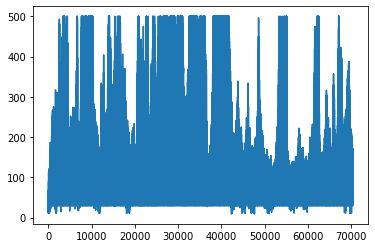

In [14]:
import matplotlib.pyplot as plt
plt.plot(stats)
plt.show()

In [15]:
algo.save_weights("saved_models/A3C")

## Test

In [8]:
# Pick algorithm to train
if(args.type=="DDQN"):
    algo = DDQN(action_dim, state_dim, args, is_eval=True)
elif(args.type=="A2C"):
    algo = A2C(action_dim, state_dim, args.consecutive_frames, is_eval=True)
elif(args.type=="A3C"):
    algo = A3C(action_dim, state_dim, args.consecutive_frames, is_atari=args.is_atari, is_eval=True)
elif(args.type=="DDPG"):
    algo = DDPG(action_dim, state_dim, act_range, args.consecutive_frames, is_eval=True)

In [9]:
algo.load_weights("saved_models/A3C_LR_0.0001_actor.h5", "saved_models/A3C_LR_0.0001_critic.h5")

In [10]:
# Reset episode
num_test_int = 10
global_info = []

for i in range(num_test_int):
    time, cumul_reward, done = 0, 0, False
    old_state = env.reset()
    
    while not done:
        env.render()
        # Actor picks an action (following the policy)
        a = algo.policy_action(np.expand_dims(old_state, axis=0))
        # Retrieve new state, reward, and whether the state is terminal
        new_state, r, done, _ = env.step(a)
        # Update current state
        old_state = new_state
        cumul_reward += r
        time += 1
        
        if done: 
            global_info.append({
                cumul_reward
            })

In [11]:
global_info

[{168.0},
 {160.0},
 {161.0},
 {165.0},
 {148.0},
 {175.0},
 {163.0},
 {166.0},
 {155.0},
 {160.0}]